# <center>Tell Me What I Don't Know</center>
#### <center>An exploration of selective summarization using the CNN Dataset</center>
<center>by Dylan Mair and Ernesto Martinez<center>

## Premise

Field Service Activity reports produced by customer support combine a natural language description with precise attributes that categorize the nature of the engagement - such as ‘who’ carried out ‘what’ with ‘whom’. The description can be very wordy, such as an attached email trail. We seek to summarize these, capturing highlights beyond our known attributes. Using T5 summarization (Raffel et al 2020) of the non-anonymized CNN-DailyMail dataset (See et al 2017) as a baseline, we seek a methodology that significantly de-emphasises what we already know to summarize the next most salient information. T5 summarization is a Transformer architecture that uses self-attention mechanisms to solve multiple text processing problems. 

We will assign one @highlight of each article as our prior knowledge. We will use ROUGE success metrics (Ganesan 2018) to determine whether our summaries resemble our labels, and cross examine labels with prior knowledge to identify and possibly exclude existing dependencies. We could try excluding prior knowledge from model training if it had consistent characteristics, however we expect to show this is not true of our analogous public dataset.

A simple solution might be to generate two summary sentences and eliminate the sentence that more closely resembles prior knowledge. The result may still contain significant prior knowledge. We will also explore the potential of using Maximal Marginal Relevance (Rachman et al 2019; Carbinell et al 2016) and Integer Linear Programming (Roth & Srikumar 2016) to select summary sentences that avoid redundant facts.

An efficient methodology may involve adjusting the model for each article to de-emphasise prior knowledge. This may resemble debiasing, however it will change for every article. Rebuilding the model each time is unlikely to be practical. We will confirm this with timing tests and compare speed and accuracy of our novel (yet to be determined) approach.


#### Sample FSA

| Example of an FSA ||
|:-----|:-------------|
| `CSA`: Adam |  `Customer`: Shell |
| `Activity`: Training | `Products`: GEPS |
| `Attendees`: Coen, Anouk, Mae, Lee, Lars, Elke** |
| `Description`: Second GEPS training for Shell, 6 attendees this time and interacting during the call with questions, one user commented that the GEPS product would be excellent for her day to day workflow when looking at competitor monitoring. I showcased the Upstream Intelligence Beta and the global impact special interest tags and alluded to the API but there was no direct interest from users. |
| `Summary for Sales`: Adam trained 6 users at Shell on GEPS. GEPS seen as excellent for competitor monitoring. Users not interested in APIs.|





1. Train the model with all highlights
2. Train the model with only the desirable highlights (exclude first highlight in each case)
3. Train the model with only the desirable highlights, while somehow 'discouraging' the set of undesirable (first) highlights.

Ultimately we seek methodologies to eliminate the first highlight in our results.

Scenario 2 is not expected to find anything systematic about the "first highlights", so the result should just be noisier (result of using a smaller training set). It will be interesting to see if there is more to this.

Scenario 3 may suffer the same problem as Scenario 2 - discouraging a set of solutions while training the whole training set is not very targeted. We might expect to find a more effective modification that is applied during prediction rather than modeling.

This is not a perfect analogue for our customer care cases, which have a very clear and systematic structure to the undesirable "highlights", such as: \<Person> \<verbed> \<X> users at \<company> using \<Product>. Unfortunately we cannot use company data for this project, so instead we're considering a case more akin to resolving "updates" to a story that go beyond the original gist extracted when the story was first published (considering perhaps that the updates are throughout the story, not simply concatenated).

But first, let's see how many highlights our stories have.

### Data Sourcing

CNN stands for Cable News Network in this case, not C Neural Network.

The CNN dataset and the DM (Daily Mail) dataset was originally created by [Hermann et al (2015)](https://arxiv.org/abs/1506.03340) by crawling the CNN website. The process was recreated by [Ramesh Nallapati et al (2016)](https://arxiv.org/abs/1602.06023) and then [See et al (2017)](https://arxiv.org/abs/1704.04368) using links to a web archive. See provided the [links to the articles in a github](https://github.com/abisee/cnn-dailymail) (in the directory `url_list`. However the data was not included subsequent to legal advice. The data was later prepared and uploaded to  [github by Jaffer Wilson](https://github.com/JafferWilson/Process-Data-of-CNN-DailyMail), tokenized but not embedded. They are provided as `CNN_STORIES_TOKENIZED.zip` and `FINISHED_FILES.zip`. However:
* `CNN_STORIES_TOKENIZED` does not identify which stories were used for training, validation or testing.
* `FINISHED_FILES.zip` (a binary repository) provides story-highlight pairs, ie. each story reproduced to pair with each of its highlights. Our ultimate workflow requires multiple highlights linked to each story.

Either dataset could be recovered. Ultimately we took the long road, chasing each URL and finding a `CCN_STORIES_TOKENIZED` story to match. This was labour intensive however the discovery of duplicates might warrant our approach. Further work might determine whether duplicates were resolved when generating `FINISHED_FILES.zip`.

Searching the `CNN_STORIES_TOKENIZED` required all stories to be loaded into memory. This was done on a local laptop while we were still resolving the Colab issue with too many files in a single directory. This search step is shown in Section 1.3 below for reference, using stories already split into train/valid/test subdirectories.

The results of Section 1.3 were then uploaded to Google Drive.

## Loading Data and Metadata

In [ ]:
!pip install transformers
!pip install rouge
!pip install sentencepiece
!pip install datasets
!pip install pytorch

     |████████████████████████████████| 2.2MB 11.0MB/s 
     |████████████████████████████████| 870kB 54.3MB/s 
     |████████████████████████████████| 3.3MB 55.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=3755a918e0d900c02852b6f3a08c900ef58955af995f1b597b718078cd821fc4
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses
     |████████████████████████████████| 1.2MB 12.4MB/s 
     |████████████████████████████████| 194kB 11.9MB/s 
     |████████████████████████████████| 112kB 17.0MB/s 
     |████████████████████████████████| 245kB 9.8MB/s 
  ERROR: Failed building wheel for pytorch
  Running setup.py clean for pytorch
Failed to build pytorch
    Running setup.py install for pytorch ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-mwbzut2_/pytorc

In [ ]:
from google.colab import drive

# sign in to mount your google drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
from google.colab import auth
auth.authenticate_user()
project_id = 'w266-301118'
!gcloud config set project {project_id}
!gsutil ls

Updated property [core/project].
gs://cnn_stories/


In [ ]:
import os
import time
import numpy as np
import pandas as pd
import collections
import torch
from transformers import AutoTokenizer, T5ForConditionalGeneration, TFT5ForConditionalGeneration, Trainer, TrainingArguments
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from datasets import Dataset
from rouge import Rouge
import nltk.data
nltk.download('punkt')

DATADIR = '/content/drive/MyDrive/cnn_data/cnn_stories_tokenized'
TOPDIR = '/content/drive/MyDrive/cnn_data'

os.chdir(TOPDIR)
print("Contents of the Top Directory:")
print(os.listdir())

# The data has already been sorted into smaller subdirectories so we can
# safely list the contens of the data directory.
# See 'Multiple Data Directories' section for details below.
os.chdir(DATADIR)
print("Contents of the Data Directory:")
print(os.listdir())
# !unzip cnn_stories.zip

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Contents of the Top Directory:
['naive_exclusion_model', 'example.story', 'finished_files', 'story_list.txt', 'cnn_stories_tokenized', 'cnn_meta.csv', 'all_stories.pkl', 'baseline_model', 'output', 'runs', 'exclude_highlights_model']
Contents of the Data Directory:
['train1', 'train2', 'train3', 'valid', 'train4', 'test']


Unzipping file uploaded to My Drive. This took 21.8 minutes to complete. Files had previously been tagged as train, validation or test articles in `cnn_meta.csv` prepared on a local computer to avoid Colab issues with too many files in one directory.

Using our metadata tags, we create three lists of files, for training, validation and testing. We do some basic filtering along the way (meta tags explained in Sidebar below).

In [ ]:
cnn_meta = pd.read_csv(TOPDIR + '/cnn_meta.csv')

print(list(cnn_meta.columns))
print("(Some) duplicate stories:", np.sum(list(cnn_meta['duplicate'])))
print("Stories with only 1 highlight:",
      np.unique(list(cnn_meta['highlights']), return_counts=True)[1][0])
print("Broken not-highlights:", np.sum(list(cnn_meta['broken'])))
print("Empty stories:", np.sum(list(cnn_meta['nostory'])))


['filenum', 'story', 'dirstory', 'train', 'validation', 'test', 'duplicate', 'source', 'highlights', 'broken', 'nostory']
(Some) duplicate stories: 14
Stories with only 1 highlight: 59
Broken not-highlights: 221
Empty stories: 119


The 4 file lists are filtered to remove duplicates, solo-highlights and non-stories (broken) and missing stories (nostory).

In [ ]:
train_meta = cnn_meta[ (cnn_meta['train'] == 1) &
                       (cnn_meta['duplicate'] == 0) &
                       (cnn_meta['highlights'] > 1) &
                       (cnn_meta['broken'] == 0) &
                       (cnn_meta['nostory'] == 0) ]
train_files = list(train_meta['dirstory'])
valid_meta = cnn_meta[ (cnn_meta['validation'] == 1) &
                       (cnn_meta['duplicate'] == 0) &
                       (cnn_meta['highlights'] > 1) &
                       (cnn_meta['broken'] == 0) &
                       (cnn_meta['nostory'] == 0) ]
valid_files = list(valid_meta['dirstory'])
test_meta = cnn_meta[ (cnn_meta['test'] == 1) &
                      (cnn_meta['duplicate'] == 0) &
                      (cnn_meta['highlights'] > 1) &
                       (cnn_meta['broken'] == 0) &
                       (cnn_meta['nostory'] == 0) ]
test_files = list(test_meta['dirstory'])
print("Train files:", len(train_files), "Validation files:",
      len(valid_files), "Test files:", len(test_files))

stories = list(cnn_meta['story'])
file_list = list(cnn_meta['dirstory'])
print("All stories", len(stories), "Files", len(file_list))

Train files: 89904 Validation files: 1182 Test files: 1081
All stories 92579 Files 92579


In [ ]:
def format_story(text):
    """Given the CNN data file, reformats to separate the story from the
    highlights. Highlights are returned as a single string"""
    
    # split the story and highlights
    split_text = text.split('\n\n@highlight\n\n')
    story = split_text[0]
    highlights = split_text[1:]
    
    # return both
    return story, highlights#'. '.join(highlights)+'.'

def cos_sims(out_sent, ref_sents):
    """gets cosine similarities for an output sentence with respect to the
    highlight sentences. Returns the sum of values."""
    
    vect = TfidfVectorizer(min_df=1, stop_words="english")                                                                                                                                                                                                   
    
    # get sentence level vectors with tf-idf
    tfidf = vect.fit_transform([out_sent] + ref_sents)
    
    # get similarity matrix
    similarity_mat = tfidf * tfidf.T
    
    # only values comparing "out_sent" with each sent in "ref_sents"
    return similarity_mat.toarray()[:1,1:][0]

In [ ]:
story_list = []
highlights_list = []

os.chdir(DATADIR)

RELOAD_DATA = False

if RELOAD_DATA:
    start = time.time()
    for i in range(len(file_list)):
    # for i in range(1000):
      file = open(file_list[i], 'r', errors='ignore')

      full_text = file.read()
      file.close()
      story, highlights = format_story(full_text)
      story_list.append(story)
      highlights_list.append(highlights)

      if (i + 1) % 500 == 0:
        print(i+1, "read")
    print('\n\ntime:', (time.time() - start) / 60, 'minutes')

    all_stories = pd.DataFrame(list(zip(file_list, story_list, highlights_list)),
                              columns =['filename', 'story', 'highlights'])
    print(all_stories.shape)
    all_stories = all_stories.set_index('filename')
    print(all_stories.shape)
    all_stories.head()

    all_stories.to_pickle(TOPDIR + '/all_stories.pkl')

if not RELOAD_DATA:
    start = time.time()
    all_stories = pd.read_pickle(TOPDIR + '/all_stories.pkl')
    print('\n\Loaded in:', time.time() - start, 'seconds')


\Loaded in: 6.025774717330933 seconds


For reference, the data loaded in 273 minutes = 5 &half; hours using Colab not-Pro (Pro not available to users in Singapore).

In [ ]:
all_stories.head()

,story,highlights
filename,,
train1/0001d1afc246a7964130f43ae940af6bc6c57f01.story,It 's official : U.S. President Barack Obama w...,[Syrian official : Obama climbed to the top of...
train1/0002095e55fcbd3a2f366d9bf92a95433dc305ef.story,-LRB- CNN -RRB- -- Usain Bolt rounded off the ...,[Usain Bolt wins third gold of world champions...
train1/00027e965c8264c35cc1bc55556db388da82b07f.story,"Kansas City , Missouri -LRB- CNN -RRB- -- The ...",[The employee in agency 's Kansas City office ...
train1/0002c17436637c4fe1837c935c04de47adb18e9a.story,Los Angeles -LRB- CNN -RRB- -- A medical docto...,[NEW : A Canadian doctor says she was part of ...
train1/0003ad6ef0c37534f80b55b4235108024b407f0b.story,-LRB- CNN -RRB- -- Police arrested another tee...,[Another arrest made in gang rape outside Cali...


### Sidebar: Making Metadata

Initially we were not aware that Colab limits files-per-directory so initial data exploration was done on a laptop * with results collated in Excel. Working backwards from the resulting metadata (sample shown below):

* *Dell Latitude 7280 laptop, 16GB RAM, Intel&reg; Core&trade; i7-6600U CPUs, 4 @ 2.60GHz, Intel&reg; HD Graphics 520, Windows 10 Enterprise.* 

In [ ]:
cnn_meta[79:89:3]

,filenum,story,dirstory,train,validation,test,duplicate,source,highlights,broken,nostory
79,79,003d23a256ce34d73e05968a04727c0ed4a2a456.story,train1/003d23a256ce34d73e05968a04727c0ed4a2a45...,1,0,0,0,0,3,0,0
82,82,003f8c8953025e086fa773c9b40d9b8cd6d9754c.story,train1/003f8c8953025e086fa773c9b40d9b8cd6d9754...,1,0,0,0,0,4,0,0
85,85,0041698b4463a633f912681b96f73648cb012e33.story,test/0041698b4463a633f912681b96f73648cb012e33....,0,0,1,0,http://web.archive.org/web/20150522032639id_/h...,2,0,0
88,88,0044e296ecfe3ba57a351ad2a36d034491e878ce.story,valid/0044e296ecfe3ba57a351ad2a36d034491e878ce...,0,1,0,0,http://web.archive.org/web/20150324215354id_/h...,2,0,0


#### Identifying Test and Validation Data

We began with the `CNN_STORIES_TOKENIZED` data which links each article to multiple highlights. In order to make any direct comparisons with prior work we sought to tag training, validation and testing articles in exactly the same way. Test articles come from April 2015; validation articles from March 2015; and training articles were published from April 2007 to February 2015. Unfortunately the publication dates were not saved with the articles so there was no direct link between these articles and their role in the modeling.

With URLs provided for 1,000+ test articles, 1,000+ validation articles, and 90,000+ training articles, we chose to manually identify just the test and validation articles, and assume everything else was training articles. Each URL was clicked on, and a piece of the resulting CNN article was pasted into a search loop to compare with the `CNN_STORIES_TOKENIZED` corpus stored in memory.

Reading all articles into memory:

In [ ]:
# This code tests a string against all of the stories, and lists any stories
# (filenames) that match. Again, those subdirectories weren't there during the
# original search.

text = 'A 16-year-old teenager has been charged for'

matches = all_stories[ all_stories['story'].str.contains(text) ]
print(*list(matches.index), sep='\n')


valid/a3a67e56b951f6dd6e53e6299e252454b5ccac8b.story


That step was done for EVERY. SINGLE. TEST and VALIDATION URL. If the string was not unique, then another string from the article was chosen.  Apostrophes and periods were modified by tokenization and so the search string would need to be adjusted accordingly.

#### Identifying Duplicates
A few duplicates were identified in this process, such as this well-worn story about the pronunciation of `GIF`:

In [ ]:
text = 'on the big screens at the Cipriani Wall'

matches = all_stories[ all_stories['story'].str.contains(text) ]
print(*list(matches.index), sep='\n')

valid/e53d78944b7c417dbf36fa1430380c4ef052c95b.story
train4/ee36e99232ee871002ce2dfbd803ae133b2b5b50.story


In [ ]:
story1 = all_stories.loc[all_stories.index ==
             'valid/e53d78944b7c417dbf36fa1430380c4ef052c95b.story',
             'story'].iloc[0]
story2 = all_stories.loc[all_stories.index ==
             'train4/ee36e99232ee871002ce2dfbd803ae133b2b5b50.story',
             'story'].iloc[0]

print(story1.replace('\n', '').replace(' .', '.\n').replace('@', '\n@'))
print('------------------------------------------------------------')
print(story2.replace('\n', '').replace(' .', '.\n').replace('@', '\n@'))

We ca n't settle iPhone vs. Android or `` Star Wars '' vs. `` Star Trek '' for you.
 But another long-running geek debate was put to rest Tuesday night.
Those short , animated loops that have captivated the Web for decades ? They 're pronounced like a brand of peanut butter.
Steve Wilhite created the Graphics Interchange Format , or GIF , while working for Compuserve in 1987.
 On Tuesday , he received a Webby Award for it and delivered his five-word acceptance speech -LRB- that 's all the Webbys allow -RRB- by flashing a GIF on the big screens at the Cipriani Wall Street in New York.
And , in a flash , it all became clear :`` It 's pronounced JIF , not GIF.
 ''Of course , in the grand tradition of heated debate , a flat statement of fact by the creator was n't enough to sway some partisans.
 On Twitter , `` GIF '' became a trending topic as some folks pushed back.
`` Graphics Interchange Format.
 Graphics.
 Not Jraphics.
 #GIF #hardg , '' wrote Web designer Dan Cederholm.
`` So instead

They're not identical ("in 2013" added to the third highlight, perhaps because the original article was published 2 years earlier) but they're almost entirely the same. Since we did not go manually through all the train story links we likely missed other duplicates but we flagged the ones we found anyway in the meta information table.

#### Minimum 2 Highlights

Our Premise, that we can downplay one summary (highlight) in favour of others, requires that we have at least two highlights. 

In [ ]:
all_stories['hlcount'] = all_stories['highlights'].str.len()

print("Total number of highlights:", all_stories['hlcount'].sum())
print("Average highlights per article:",round(all_stories['hlcount'].mean(),3))
print("Count of number of highlights per article:\n",
      all_stories.groupby('hlcount')['hlcount'].count())

Total number of highlights: 329439
Average highlights per article: 3.558
Count of number of highlights per article:
 hlcount
1       59
2     3028
3    34691
4    54754
5       47
Name: hlcount, dtype: int64


We have just 59 articles that have only 1 highlight. They represent a tiny proportion of the articles. We tag them in the meta data and we will likely eliminate those entirely.

We compare this with the number of pairs that See et al (2017, "Get to the Point") used in their dataset - which had been carefully aligned with prior work by using the same cleanup script that prior authors (Nallapati et al., 2016, 2017) had used. Unfortunately this script is not attached to any of the relevant papers. As we go along we might find further reasons for cleanup affecting 17K highlights (such as the length of such highlights).

That's 17,256 pairs more in our data, than in the data used by other authors. We can definitely cut more aggressively here. Let's explore the size of train and test used by See et al:


In [ ]:
# 287,226 training pairs, 13,368 validation pairs and 11,490 test pairs.

x = 3028 * 2 + 34691 * 3 + 54754 * 4 + 47 * 5
print("Number of pairs in our dataset:", x)
print("Difference with See:", x - 287266 - 13368 - 11490)


Number of pairs in our dataset: 329380
Difference with See: 17256


In [ ]:
# 287,226 training pairs, 13,368 validation pairs and 11,490 test pairs.

see_pairs = 287226 + 13368 + 11490
print("See training %", round(100*287226/see_pairs, 2))
print("See validation (dev) %", round(100*13368/see_pairs, 2))
print("See test %", round(100*11490/see_pairs, 2))

See training % 92.03
See validation (dev) % 4.28
See test % 3.68


Interesting facts from Hermann, 2015, regarding creation of this dataset:

Table 1: Corpus statistics. Articles were collected starting in April 2007 for CNN and June 2010 for the Daily Mail, both until the end of April 2015. Validation data is from March, test data from April 2015. Articles of over 2000 tokens and queries whose answer entity did not appear in the context were filtered out.

At this point we realize the Daily Mail articles are definitely missing from our dataset. Do we want to bring them in later? Do we ignore them for the homework?

Hermann paper: https://arxiv.org/pdf/1506.03340.pdf


#### Broken highlights

Along the way we explored the length of the highlights, in words. They had a strange distribution:

Number of @highlights: 329439


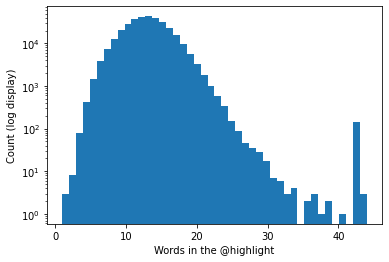

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

all_stories = all_stories.assign(hl_lens=[[len(k.split()) for k in row] for
                                          row in all_stories.highlights])

flat_hl_words = [ x for nums in list(all_stories['hl_lens']) for x in nums ]

print("Number of @highlights:", len(flat_hl_words))

plt.hist(flat_hl_words, density=False, bins=44)  # density=False gives counts
plt.ylabel('Count (log display)')
plt.yscale('log')
plt.xlabel('Words in the @highlight');

There are definitely some peculiar results happening for highlights over 40 words long. Let's take a look:

In [ ]:
for index, row in all_stories.iterrows():
    for hl in range(len(row['hl_lens'])):
        if row['hl_lens'][hl] > 42:
            print(index, 'highlight', hl, 'has', row['hl_lens'][hl], 'words: ',
                  row['highlights'][hl])

train1/00f222d27b211c4d83e77f297ccfebe6a652f900.story highlight 2 has 43 words:  At the bottom of the page , comment for a chance to be mentioned on CNN Student News . You must be a teacher or a student age 13 or older to request a mention on the CNN Student News Roll Call .
valid/027388f2c138301038249446d8c71170f470e83a.story highlight 2 has 43 words:  At the bottom of the page , comment for a chance to be mentioned on CNN Student News . You must be a teacher or a student age 13 or older to request a mention on the CNN Student News Roll Call .
train1/034c096518e949eb207d14af18dffd39549eb084.story highlight 2 has 43 words:  At the bottom of the page , comment for a chance to be mentioned on CNN Student News . You must be a teacher or a student age 13 or older to request a mention on the CNN Student News Roll Call .
train1/03ea986d6ea03bbbf7851bbc4e0b92bfbb0c4e68.story highlight 2 has 43 words:  At the bottom of the page , comment for a chance to be mentioned on CNN Student News . You m

Okay, that was grim. All those items with 43 words seem identical. Let's look at one of them.

In [ ]:
print(fullitems[92451].replace('\n', '').replace(' .', '.\n').replace('@', '\n@'))

-LRB- CNN Student News -RRB- -- October 29 , 2014If you know what the southernmost U.S. state is , then you know where we 're going for one of the stories on today 's show.
 The location 's slow-moving natural disaster is a study in geology and earth science.
 Also featured is a debate concerning quarantines and the Ebola virus.
 And we look inside a plane that appears to be made of giant windows , though it actually has none for passengers.
On this page you will find today 's show Transcript and a place for you to request to be on the CNN Student News Roll Call.
TRANSCRIPTClick here to access the transcript of today 's CNN Student News program.
Please note that there may be a delay between the time when the video is available and when the transcript is published.
CNN Student News is created by a team of journalists who consider the Common Core State Standards , national standards in different subject areas , and state standards when producing the show.
ROLL CALLFor a chance to be ment

In [ ]:
for index, row in all_stories.iterrows():
    for hl in range(len(row['hl_lens'])):
        if row['hl_lens'][hl] < 3:
            print(index, 'highlight', hl, 'has', row['hl_lens'][hl], 'words: ',
                  row['highlights'][hl])

train1/0e4bc29471e4ffa620e415545bc346125978579a.story highlight 2 has 1 words:  Hoy
train2/67b80daf1af70b724a810788b8714e8a63af2a19.story highlight 0 has 2 words:  NEW :
train2/705c762be1488af409da95bece16ee68c1f2671e.story highlight 0 has 2 words:  NEW :
train3/9f5a789344f92ea35c2fba5f7bc83ad36ba64973.story highlight 0 has 2 words:  NEW :
train3/a6608069b26f03b21bfff528e66e26389de0d48c.story highlight 0 has 1 words:  NEW
train3/ac89f9a5d16ddc35ad5bf273f2252ea19e5dc3f4.story highlight 3 has 1 words:  She
train3/b6cdedc2ed9f81b26474cec4df5b733727972778.story highlight 0 has 2 words:  NEW :
train3/beb65b8103bfb7ca229752a8ccfba077a41a5039.story highlight 0 has 2 words:  NEW :
train3/c44fb6d8cf7a2a8339aad828befdc0e298c41f49.story highlight 0 has 2 words:  Shooter identified
train4/cf3e5d84d63daf2b7ac121370b9e10d3ec437e87.story highlight 0 has 2 words:  NEW :
train4/f2422026814d2464b5f59db2668213fca26ebb05.story highlight 3 has 2 words:  Brown has


It's a landing page for a set of articles, not an article itself. While the short highlights ("NEW"!) are poor, these items look utterly disposable. For simplicity, we choose to tag all highlights over 40 words as `broken` in the metadata. This amounts to 143 articles, increasing our broken count to 221.

In [ ]:
np.sum(list(cnn_meta['broken']))

221

Further broken stories were identified when looking at small files on disk (searching for a nice short example to show in the paper). Specifically, there is a population of articles that represent landing pages for video articles.

```
highlights[1785]
["-LRB- CNN Student News -RRB- -- February 8 , 2013\n\nDownload PDF maps related to today 's show :\n\nMontgomery , Alabama ; Selma , Alabama ; Little Rock , Arkansas ; Washington , D.C.\nChina\n\nClick here to access the transcript of today 's CNN Student News program .\n\nPlease note that there may be a delay between the time when the video is available and when the transcript is published .",
 "The daily transcript is a written version of each day 's CNN Student News program",
 'Use this transcript to help students with reading comprehension and vocabulary',
 'Use the weekly Newsquiz to test your knowledge of stories you saw on CNN Student News']
 ```

In [ ]:
text = 'Use this transcript to help students'

for index, row in all_stories.iterrows():
    for hl in range(len(row['highlights'])):
        if text in row['highlights'][hl]:
            print(index, 'has highlights', *list(row['highlights']))

train1/04ff02e815e31dd23dbc3adfbf2ba0a86da2b80d.story has highlights The daily transcript is a written version of each day 's CNN Student News program Use this transcript to help students with reading comprehension and vocabulary Use the weekly Newsquiz to test your knowledge of stories you saw on CNN Student News
train1/07f388a7cc70c658e7b954984dfed448cfd80524.story has highlights The daily transcript is a written version of each day 's CNN Student News program Use this transcript to help students with reading comprehension and vocabulary Use the weekly Newsquiz to test your knowledge of stories you saw on CNN Student News
train1/0cd484f58d6ec1873d685aec7f73fa641ed180e1.story has highlights The daily transcript is a written version of each day 's CNN Student News program Use this transcript to help students with reading comprehension and vocabulary Use the weekly Newsquiz to test your knowledge of stories you saw on CNN Student News
train1/0f080014669246c0ed9dd117f4bcc0e3a4944bcf.stor

#### Broken stories

Some stories have no text at all. Any story less than 200 characters has little meaning.

In [ ]:
matches = all_stories[ all_stories['story'].str.len() < 200 ]

for index, row in matches.iterrows():
    print(index, 'story < 200 words:', row['story'])

train1/00465603227f7f56fcd37e10f4cd44e57d7647d8.story story < 200 words: 
train1/07bca124a8b784800aa38e6237524eb756792c7c.story story < 200 words: 
train1/09ac649da7f5ae27d3a7ef47eeb9b8ea4cbd799c.story story < 200 words: 
train1/0de44dd3a66327f990e4f21b2c672424a07dbfb7.story story < 200 words: 
train1/118e01697b58e37f56bd03004a608a6b3126e384.story story < 200 words: 
train1/13abd3e35628071686b33a3b9201cd09da4e1a01.story story < 200 words: 
train1/158501546d04c78797fe4aa887540514469fa87d.story story < 200 words: 
train1/15e1efd925d246b6a93cda25fc3677e923081722.story story < 200 words: 
train1/17201d7e00b4227c985c8dd6ce80c925865d4720.story story < 200 words: 
train1/17c0b96f8b303bcf8ae6d4fc3f9776e535805d4f.story story < 200 words: 
train1/1963afbc839123244fa3c483b7d5256bf057f758.story story < 200 words: 
train1/1a00c87c9d1d192f103d6ccf2ad76062f2229609.story story < 200 words: 
train1/1a918e011f1952ed5c37c48c0b5f7350f804f865.story story < 200 words: 
train1/1b281d4630a5f53acbdf0add94372b0

### Multiple Data Directories

Owing to the vaguaries of Colab, we needed to split our data into multiple directories. This was simply achieved by creating subdirectories, and adding names to our metadata that includes those names (the variable `dirstory`).

Names were generated in Excel using the formula:
```Excel
=IF(E2,CONCAT("valid/",B2),IF(F2,CONCAT("test/",B2),IF(D2,CONCAT("train",INT(A2/25000)+1,"/",B2),"None")))
```
* Column E = `validation`
* Column F = `test`
* Column D = `train` ; Column A = `filenum`
* Column B = `story` (.story filename)

Simply, test stories go into a test subdirectory; validation stories go into a "valid" subdirectory; and train stories go into train directory number int(filenum/25000)+1. The 90101 train stories end up in 4 directories.

The code to move the files is shown below. It was executed on our laptops, the result was zipped and uploaded to our Google Drive as described above.

In [ ]:
import shutil

SUBDIR_THE_FILES = False

if SUBDIR_THE_FILES:
    os.chdir(DATADIR)

    if not os.path.isdir('train1'):
        os.mkdir('train1')
    if not os.path.isdir('train2'):
        os.mkdir('train2')
    if not os.path.isdir('train3'):
        os.mkdir('train3')
    if not os.path.isdir('train4'):
        os.mkdir('train4')
    if not os.path.isdir('test'):
        os.mkdir('test')
    if not os.path.isdir('valid'):
        os.mkdir('valid')

    i = 0
    for i in range(len(list(cnn_meta['dirstory']))):
        if i % 5000 == 1:
            print("Story", i)
        if os.path.isfile("./" + stories[i]):
            shutil.move("./" + stories[i], "./" + file_list[i])

    os.chdir(TOPDIR)

### "Known Data" Testing

Prior to any modeling, we can assess how similar (or not) the "known data" (our first highlight) is to the other highlights. Ideally they won't match!

We begin this exercise using just ROUGE-1-F, as that was the metric chosen in previous CNN studies. But instead of comparing a generated summary with a reference summary, we compare the first reference summary with the other reference summaries.

Because we're so rigorous, we also compare the last reference summary with the other reference summaries, to see if perhaps the CNN editors get lazy, or maybe even better with time...



In [ ]:
# all_hlighlights was defined above to capture all of the highlights
# according to:
# all_highlights[i] = fullitems[i].split('\n\n@highlight\n\n')[1:]

print(fullitems[1].replace('\n', '').replace(' .', '.\n').replace('@', '\n@'))
print("   - - - - - - - - - ")
all_highlights[1]


-LRB- CNN -RRB- -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men 's 4x100m relay.
The fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter , Kemar Bailey-Cole , Nickel Ashmeade and Bolt won in 37.36 seconds.
The U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover.
The 26-year-old Bolt has now collected eight gold medals at world championships , equaling the record held by American trio Carl Lewis , Michael Johnson and Allyson Felix , not to mention the small matter of six Olympic titles.
The relay triumph followed individual successes in the 100 and 200 meters in the Russian capital.
`` I 'm proud of myself and I 'll continue to work to dominate for as long as possible , '' Bolt said , having previously expressed his intention to carry on until the 2016 Rio Olympics.


['Usain Bolt wins third gold of world championship',
 'Anchors Jamaica to 4x100m relay victory',
 'Eighth gold at the championships for Bolt',
 "Jamaica double up in women 's 4x100m relay"]

So let's ROUGE.

In [ ]:


from rouge import Rouge
import numpy as np

rouge = Rouge()

rouge.get_scores(highlights[1][0], highlights[1][1])[0]['rouge-1']['f']

0.024054982546734216

In [ ]:
from rouge import Rouge
import numpy as np

highs = 0
scores = [ [] for x in range(len(all_highlights)) ]
rouge = Rouge()

for story in range(len(all_highlights)):
    if story % 5000 == 1:
        print("Story:", story)
    highs += len(all_highlights[story]) - 1
    hlsc = []
    for hl in range(1, len(all_highlights[story])):
        hlsc.append(rouge.get_scores(all_highlights[story][0],
                                     all_highlights[story][hl])[0]['rouge-1']['f'])
    scores[story] = hlsc
#    scores[story] = max(hlsc)

print(highs / 90101)
flat_scores = [ x for nums in scores for x in nums ]
len(flat_scores)
# len(scores)


Story: 1
Story: 1001
Story: 2001
Story: 3001
Story: 4001
Story: 5001
Story: 6001
Story: 7001
Story: 8001
Story: 9001
Story: 10001
Story: 11001
Story: 12001
Story: 13001
Story: 14001
Story: 15001
Story: 16001
Story: 17001
Story: 18001
Story: 19001
Story: 20001
Story: 21001
Story: 22001
Story: 23001
Story: 24001
Story: 25001
Story: 26001
Story: 27001
Story: 28001
Story: 29001
Story: 30001
Story: 31001
Story: 32001
Story: 33001
Story: 34001
Story: 35001
Story: 36001
Story: 37001
Story: 38001
Story: 39001
Story: 40001
Story: 41001
Story: 42001
Story: 43001
Story: 44001
Story: 45001
Story: 46001
Story: 47001
Story: 48001
Story: 49001
Story: 50001
Story: 51001
Story: 52001
Story: 53001
Story: 54001
Story: 55001
Story: 56001
Story: 57001
Story: 58001
Story: 59001
Story: 60001
Story: 61001
Story: 62001
Story: 63001
Story: 64001
Story: 65001
Story: 66001
Story: 67001
Story: 68001
Story: 69001
Story: 70001
Story: 71001
Story: 72001
Story: 73001
Story: 74001
Story: 75001
Story: 76001
Story: 77001

236860

In [ ]:
np.mean(flat_scores)

0.10749471120951053

In [ ]:
r_highs = 0
r_scores = [ [] for x in range(len(all_highlights)) ]
rouge = Rouge()

for story in range(len(all_highlights)):
    if story % 5000 == 1:
        print("Story:", story)
    r_highs += len(all_highlights[story]) - 1
    r_hlsc = []
    for hl in range(0, len(all_highlights[story]) - 1):
        r_hlsc.append(rouge.get_scores(all_highlights[story][-1],
                                     all_highlights[story][hl])[0]['rouge-1']['f'])
    r_scores[story] = r_hlsc
#    scores[story] = max(hlsc)

print(highs / 92579)
r_flat_scores = [ x for nums in r_scores for x in nums ]
len(r_flat_scores)
# len(scores)

Story: 1
Story: 5001
Story: 10001
Story: 15001
Story: 20001
Story: 25001
Story: 30001
Story: 35001
Story: 40001
Story: 45001
Story: 50001
Story: 55001
Story: 60001
Story: 65001
Story: 70001
Story: 75001
Story: 80001
Story: 85001
Story: 90001
2.6288276489717095


236860

In [ ]:
print(r_highs / 92579)
print(highs / 92579)
np.mean(r_flat_scores)

2.5584635824539044
2.5584635824539044


0.1019264738939428

T5 paper: The primary building block of the Transformer is self-attention (Cheng et al., 2016). Self-attention is a variant of attention (Graves, 2013; Bahdanau et al., 2015) that processes a sequence by replacing each element by a weighted average of the rest of the sequence.

Overall, our encoder-decoder Transformer implementation closely follows its originally proposed form (Vaswani et al., 2017). First, an input sequence of tokens is mapped to a sequence of embeddings, which is then passed into the encoder. The encoder consists of a stack of “blocks”, each of which comprises two subcomponents: a self-attention layer followed by a small feed-forward network. Layer normalization (Ba et al., 2016) is applied to the input of each subcomponent. We use a simplified version of layer normalization where
the activations are only rescaled and no additive bias is applied. After layer normalization, a residual skip connection (He et al., 2016) adds each subcomponent’s input to its output.
Dropout (Srivastava et al., 2014) is applied within the feed-forward network, on the skip connection, on the attention weights, and at the input and output of the entire stack. The decoder is similar in structure to the encoder except that it includes a standard attention mechanism after each self-attention layer that attends to the output of the encoder. The self-attention mechanism in the decoder also uses a form of autoregressive or causal selfattention,
which only allows the model to attend to past outputs. The output of the final
decoder block is fed into a dense layer with a softmax output, whose weights are shared with the input embedding matrix. All attention mechanisms in the Transformer are split up into independent “heads” whose outputs are concatenated before being further processed.

In this work, we use 32 embeddings for all of our models with ranges that increase in size logarithmically up to an offset of 128 beyond which we assign all relative positions to the same embedding. Note that a given layer is insensitive to relative position beyond 128 tokens, but subsequent layers
can build a sensitivity to larger offsets by combining local information from previous layers.

we use a combination of model and data parallelism and train models on “slices” of Cloud TPU Pods.5 TPU pods are are multi-rack ML supercomputers that contain 1,024 TPU v3 chips connected via a high-speed 2D mesh interconnect with
supporting CPU host machines. We leverage the Mesh TensorFlow library (Shazeer et al., 2018) for ease of implementation of both model parallelism and data parallelism (Krizhevsky, 2014).

The CNN/Daily Mail (Hermann et al., 2015) data set was introduced as a question answering task but was adapted for text summarization by Nallapati et al. (2016); we use the non-anonymized version from See et al. (2017) as an abstractive summarization task. SQuAD (Rajpurkar et al., 2016) is a common question- answering benchmark. In our experiments, the model is fed the question and its context and asked to generate the answer token-by-token.

Note that the choice of text prefix used for a given task is essentially a hyperparameter; we found that changing the exact wording of the prefix had limited impact and so did not perform extensive experiments into different prefix choices.

Our baseline model is designed so that the encoder and decoder are each similar in size and configuration to a “BERTBASE” (Devlin et al., 2018) stack. Specifically, both the encoder and decoder consist of 12 blocks (each block comprising self-attention, optional encoder-decoder attention, and a feed-forward network). The feed-forward networks in each block consist of a dense layer with an output dimensionality of dff = 3072 followed by a ReLU nonlinearity and another dense layer. The “key” and “value” matrices of all attention mechanisms have an inner dimensionality of dkv = 64 and all attention mechanisms have 12 heads. All other sub-layers and embeddings have a dimensionality of dmodel = 768. In total, this results in a model with about 220 million parameters. This is roughly twice the number of parameters of BERTBASE since our baseline model contains two layer stacks instead of one. For regularization, we use a dropout probability of 0.1 everywhere dropout is applied in the model.

we use a vocabulary of 32,000 wordpieces.

As a cheaper alternative, we train our baseline model 10 times from scratch (i.e. with different random initializations and data set shuffling) and assume that the variance over these runs of the base model also applies to each experimental variant. We don’t expect most of the changes we make to have a dramatic effect on the inter-run variance, so this should provide a reasonable indication of the significance of different changes.

For CNN/Daily Mail, we find the performance of models on the ROUGE-1-F, ROUGE-2-F, and ROUGE-L-F metrics (Lin, 2004) to be highly correlated so we report the ROUGE-2-F score alone under the heading “CNNDM”.

[regarding baselines, pre-training is marginal for very large datasets but our CNN dataset is not very large]



# I. Setup

In [ ]:
import os
import time
import numpy as np
import pandas as pd
import collections

import torch
from transformers import AutoTokenizer, T5ForConditionalGeneration, TFT5ForConditionalGeneration, Trainer, TrainingArguments
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from datasets import Dataset
from rouge import Rouge
import nltk.data
nltk.download('punkt')

ModuleNotFoundError: ignored

#### Some functions for convenience later

In [ ]:
def cos_sims(out_sent, ref_sents):
    """gets cosine similarities for an output sentence with respect to the
    highlight sentences. Returns the sum of values."""
    
    vect = TfidfVectorizer(min_df=1, stop_words="english")                                                                                                                                                                                                   
    
    # get sentence level vectors with tf-idf
    tfidf = vect.fit_transform([out_sent] + ref_sents)
    
    # get similarity matrix
    similarity_mat = tfidf * tfidf.T
    
    # only values comparing "out_sent" with each sent in "ref_sents"
    return similarity_mat.toarray()[:1,1:][0]

In [ ]:
# move up one directory (models will be stored here)
os.chdir(TOPDIR)
print(os.getcwd())

/content/drive/MyDrive/cnn_data


# II. Models

## A. Pre-trained

Load a Pre-trained T5 Model and Tokenizer

In [ ]:
# pretrained t5 model
model = T5ForConditionalGeneration.from_pretrained('t5-small')

# t5 tokenizer
tokenizer = AutoTokenizer.from_pretrained('t5-small')

def tokenize(batch):
    """Applies tokenizer to a whole dataset at once. Input is a dataset with raw text data, 
    and output is a dataset with tokenized data"""
    
    tokenized_input = tokenizer(batch['source'], padding='max_length', truncation=True)
    tokenized_label = tokenizer(batch['target'], padding='max_length', truncation=True)
    tokenized_input['labels'] = tokenized_label['input_ids']
    return tokenized_input

### Let's get some baseline loss values




In [ ]:
# check some stories for pre-training loss
for i in range(5):
    
    # get formatted input and target
    story = all_stories.loc[valid_files[i],'story']
    highlights = all_stories.loc[valid_files[i],'highlights']
    
    # tokenize output and labels
    input_ids = tokenizer('summarize: ' + story, return_tensors='pt').input_ids
    labels = tokenizer(highlights[0], return_tensors='pt').input_ids
    
    # compute loss (this returns an array of things)
    loss = model(input_ids=input_ids, labels=labels).loss
    
    # print loss (sum of array values above)
    print(loss)

Token indices sequence length is longer than the specified maximum sequence length for this model (604 > 512). Running this sequence through the model will result in indexing errors


tensor(1.6187, grad_fn=<NllLossBackward>)
tensor(3.1245, grad_fn=<NllLossBackward>)
tensor(4.4393, grad_fn=<NllLossBackward>)
tensor(4.4850, grad_fn=<NllLossBackward>)
tensor(4.3491, grad_fn=<NllLossBackward>)


## A. Multisentence Baseline



### Data Formatting

Right now, we have a text file for each story. T5 requires a single matrix (a dataset object is perfect) with source/target columns. For this model, the target is now a paragraph composed of the joined highlights for a given story.

In [ ]:
# collect train data in the format required for this next model
source_text_train = []
target_text_train = []

start = time.time()

for i in range(len(train_files)):
    
    # get formatted input and target
    # story, highlights = format_story(train_files[i])
    story = all_stories.loc[train_files[i],'story']
    highlights = all_stories.loc[train_files[i],'highlights']
    
    
    # format data as story/joined highlights pairs
    source_text_train.append(story)
    target_text_train.append('. '.join(highlights)+'.')

# print the time this took in minutes
print('\n\ntime:', (time.time()-start)/60,'minutes')
print('')

train_df = pd.DataFrame(list(zip(source_text_train, target_text_train)),columns =['source', 'target'])
train_dataset = Dataset.from_pandas(train_df)
print(train_dataset)



time: 0.03051092227300008 minutes

Dataset({
    features: ['source', 'target'],
    num_rows: 89904
})


In [ ]:
# collect val data in the format required for this next model
source_text_val = []
target_text_val = []

start = time.time()

for i in range(len(valid_files)):
    
    # get formatted input and target
    story = all_stories.loc[valid_files[i],'story']
    highlights = all_stories.loc[valid_files[i],'highlights']
    
    # format data as story/joined highlights pairs
    source_text_val.append(story)
    target_text_val.append('. '.join(highlights)+'.')

# print the time this took in minutes
print('\n\ntime:', (time.time()-start)/60,'minutes')

# format as a dataset
val_df=pd.DataFrame(list(zip(source_text_val,target_text_val)),columns=['source','target'])
val_dataset = Dataset.from_pandas(val_df)
print(val_dataset)



time: 0.0004948814709981283 minutes
Dataset({
    features: ['source', 'target'],
    num_rows: 1182
})


In [ ]:
print('='*60+'\nEXAMPLE INPUT TEXT\n'+'='*60)
print(source_text_train[0])
print('='*60+'\nEXAMPLE TARGET TEXT\n'+'='*60)
print(target_text_train[0])

EXAMPLE INPUT TEXT
It 's official : U.S. President Barack Obama wants lawmakers to weigh in on whether to use military force in Syria .

Obama sent a letter to the heads of the House and Senate on Saturday night , hours after announcing that he believes military action against Syrian targets is the right step to take over the alleged use of chemical weapons .

The proposed legislation from Obama asks Congress to approve the use of military force `` to deter , disrupt , prevent and degrade the potential for future uses of chemical weapons or other weapons of mass destruction . ''

It 's a step that is set to turn an international crisis into a fierce domestic political battle .

There are key questions looming over the debate : What did U.N. weapons inspectors find in Syria ? What happens if Congress votes no ? And how will the Syrian government react ?

In a televised address from the White House Rose Garden earlier Saturday , the president said he would take his case to Congress , not

### Tokenize Data

In [ ]:
train_tokenized = train_dataset.map(tokenize, batched=True, batch_size=512)
val_tokenized = val_dataset.map(tokenize, batched=True, batch_size=len(val_dataset))
print(val_tokenized)

### Train

In [ ]:
output_dir = 'multisentence_model'

# training arguments to feed to Trainer object
training_args = TrainingArguments(
    output_dir = 'baseline_model', # trained model will be saved here
    num_train_epochs = 2, # number of times each story will be touched
    per_device_train_batch_size = 8, # number of examples per batch
    per_device_eval_batch_size = 8, # number of examples per batch
    eval_accumulation_steps = 1,
    prediction_loss_only = True,
    learning_rate = 0.001,
    evaluation_strategy = 'steps',
    save_steps = 10,
    save_total_limit = 1,
    remove_unused_columns = True,
    run_name = 'run_name',
    logging_steps = 500, # print loss after this many steps
    eval_steps = 500, # calculate loss after this many steps
    logging_first_step = False,
    load_best_model_at_end = True,
    metric_for_best_model = "loss", 
    greater_is_better = False
)

# create Trainer to feed the train/dev data
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_tokenized,
    eval_dataset = val_tokenized
)

# train the model and save it to our directory
trainer.train()
trainer.save_model(output_dir + '/model')

Step,Training Loss,Validation Loss,Runtime,Samples Per Second
500,0.294500,0.222355,21.765000,54.307000
1000,0.296300,0.223391,21.768200,54.299000
1500,0.293100,0.222032,21.787000,54.253000
2000,0.290700,0.221767,21.848300,54.100000
2500,0.294800,0.221399,21.795700,54.231000
3000,0.292700,0.223435,21.798000,54.225000
3500,0.288700,0.222823,21.876000,54.032000
4000,0.289300,0.221721,21.853300,54.088000
4500,0.292700,0.221715,21.840000,54.121000
5000,0.291100,0.220129,21.855800,54.082000




time: 173.88504872719446 minutes


### Evaluate

__ROUGE__

In [ ]:
# load our model
multi_model = T5ForConditionalGeneration.from_pretrained('baseline_model/model')

# for scoring outputs
rouge = Rouge()

scores = []

for i in range(len(test_files)):
    # format the text to input/target format
    story = all_stories.loc[test_files[i],'story']
    highlights = all_stories.loc[test_files[i],'highlights']

    # encode the input
    encoded = tokenizer.encode('summarize: '+story, return_tensors='pt')

    # generate the output
    output = multi_model.generate(encoded, num_beams=4, no_repeat_ngram_size=2,
                             min_length=30, max_length=300, early_stopping=True)
    summary = tokenizer.decode(output[0])

    if 1%10==0:
      print(i,'stories passed')
    
    # get ROUGE scores between output and highlights
    score = rouge.get_scores(summary,'. '.join(highlights)+'.')[0]['rouge-1']['f']
    
    scores.append(score)

print('ROUGE F1:',np.mean(scores))

0 files passed
1 files passed
2 files passed
3 files passed
4 files passed
5 files passed
6 files passed
7 files passed
8 files passed
9 files passed
10 files passed
11 files passed
12 files passed
13 files passed
14 files passed
15 files passed
16 files passed
17 files passed
18 files passed
19 files passed
20 files passed
21 files passed
22 files passed
23 files passed
24 files passed
25 files passed
26 files passed
27 files passed
28 files passed
29 files passed
30 files passed
31 files passed
32 files passed
33 files passed
34 files passed
35 files passed
36 files passed
37 files passed
38 files passed
39 files passed
40 files passed
41 files passed
42 files passed
43 files passed
44 files passed
45 files passed
46 files passed
47 files passed
48 files passed
49 files passed
50 files passed
51 files passed
52 files passed
53 files passed
54 files passed
55 files passed
56 files passed
57 files passed
58 files passed
59 files passed
60 files passed
61 files passed
62 files passed
63

### How did Training affect the loss?

In [ ]:
# collect test data in the format required for this next model
source_text_test = []
target_text_test = []

start = time.time()

for i in range(len(test_files)):
# for i in range(5):
    
    # get formatted input and target
    story = all_stories.loc[test_files[i],'story']
    highlights = all_stories.loc[test_files[i],'highlights']
    
    # format data as story/joined highlights pairs
    source_text_test.append(story)
    target_text_test.append('. '.join(highlights)+'.')

# print the time this took in minutes
print('\n\ntime:', (time.time()-start)/60,'minutes')

# format test data as dataset
test_df = pd.DataFrame(list(zip(source_text_test, target_text_test)),columns =['source', 'target'])
test_dataset = Dataset.from_pandas(test_df)
test_tokenized = test_dataset.map(tokenize, batched=True, batch_size=len(val_dataset))
print(test_dataset)

# evaluate the model on the test dataset
eval_args = TrainingArguments(
    per_device_eval_batch_size=8,
    # remove_unused_columns=True,
    eval_accumulation_steps=1,
    output_dir = 'output'
)

trainer = Trainer(model=multi_model, args=eval_args)

trainer.evaluate(test_tokenized)



time: 0.0005159616470336914 minutes
Dataset({
    features: ['source', 'target'],
    num_rows: 1081
})


{'eval_loss': 0.20515315234661102,
 'eval_mem_cpu_alloc_delta': 117921,
 'eval_mem_cpu_peaked_delta': 170250,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_gpu_peaked_delta': 1279395840,
 'eval_runtime': 21.2569,
 'eval_samples_per_second': 50.854,
 'init_mem_cpu_alloc_delta': 531146,
 'init_mem_cpu_peaked_delta': 30967345,
 'init_mem_gpu_alloc_delta': 0,
 'init_mem_gpu_peaked_delta': 0}

In [ ]:
multi_model = T5ForConditionalGeneration.from_pretrained('baseline_model/model')

# collect test data in the format required for this next model
source_text_test = []
target_text_test = []

start = time.time()

for i in range(len(test_files)):
# for i in range(5):
    
    # get formatted input and target
    story = all_stories.loc[test_files[i],'story']
    highlights = all_stories.loc[test_files[i],'highlights']
    
    # format data as story/joined highlights pairs
    source_text_test.append(story)
    target_text_test.append('. '.join(highlights)+'.')

# print the time this took in minutes
print('\n\ntime:', (time.time()-start)/60,'minutes')

# format test data as dataset
test_df = pd.DataFrame(list(zip(source_text_test, target_text_test)),columns =['source', 'target'])
test_dataset = Dataset.from_pandas(test_df)
test_tokenized = test_dataset.map(tokenize, batched=True, batch_size=len(val_dataset))
print(test_dataset)

# evaluate the model on the test dataset
eval_args = TrainingArguments(
    per_device_eval_batch_size=8,
    # remove_unused_columns=True,
    eval_accumulation_steps=1,
    output_dir = 'output'
)

trainer = Trainer(model=multi_model, args=eval_args)

trainer.evaluate(test_tokenized)



time: 0.0003548860549926758 minutes



Dataset({
    features: ['source', 'target'],
    num_rows: 1081
})


{'eval_loss': 0.29979559779167175,
 'eval_mem_cpu_alloc_delta': -30633984,
 'eval_mem_cpu_peaked_delta': 30633984,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_gpu_peaked_delta': 1279395840,
 'eval_runtime': 21.0785,
 'eval_samples_per_second': 51.285,
 'init_mem_cpu_alloc_delta': -11374592,
 'init_mem_cpu_peaked_delta': 11374592,
 'init_mem_gpu_alloc_delta': 242026496,
 'init_mem_gpu_peaked_delta': 0}

### Excluding Known Information with TF-IDF

Let's trim the sentence most like a "known highlight". We can use TF-IDF to vectorize each sentence, and cmopare cosine similarities.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# make up some similar sentences
s0 = """I am trying as best I can, using as many words as I can, to make this sentence as long as possible,
        though it has little meaning."""
s1 = 'I am trying as best I can, using as many words as I can, to make this sentence as long as possible.'
s2 = 'I am trying as best I can to make this sentence as long as possible.'
s3 = 'I am trying to make this sentence as long as possible.'

# add in a totally different sentence
s4 = 'Liver tastes terrible.'

def cos_sims(out_sent, ref_sents):
    vect = TfidfVectorizer(min_df=1, stop_words="english")                                                                                                                                                                                                   
    tfidf = vect.fit_transform([out_sent] + ref_sents)  

    similarity_mat = tfidf * tfidf.T

    return similarity_mat.toarray()[:1,1:][0]

similarities = cos_sims(s0,[s1,s2,s3,s4])

print('similarity of s0 to:') 
for i in range(4):
    print('s'+str(i+1),'=',similarities[i])
    print(str(1))

In [ ]:
# encode the summary
encoded = tokenizer.encode('summarize: ' + story.replace('\n',' '), return_tensors='tf')

# decode
output = multi_model.generate(encoded, num_beams=4, no_repeat_ngram_size=2,
                         min_length=30, max_length=300, early_stopping=True)
summary = tokenizer.decode(output[0])

# split the summary into sentences
splitter = nltk.data.load('tokenizers/punkt/english.pickle')

scores = []
for sent in summ_sentences:
    score = cos_sims(sent,[highlights[0]])
    scores.append(score)


# output the sentence with the least similarity to highlights
print('Known Info:')
print(highlights[0])
print('~'*60)
print('Closest Match:')
summ_sentences[scores.index(max(scores))]
print('~'*60)
print('Novel Info:')

# remove the sentence most similar
summ_sentences.pop(scores.index(max(scores)))
print('. '.join(summ_sentences))

Token indices sequence length is longer than the specified maximum sequence length for this model (1173 > 512). Running this sequence through the model will result in indexing errors


NameError: ignored

## B. Single Sentence Summaries

This model uses single sentence summaries, more in line with the summarization benchmarking tokenization task often referenced in the literature.

### Data Formatting

Right now, we have a text file for each story. T5 requires a single matrix (a dataset object is perfect) with source/target columns.

In [ ]:
# collect train data from all_stories
source_text_train = []
target_text_train = []

start = time.time()

for i in range(len(train_files)):
# for i in range(10):
    
    # get formatted input and target
    story = all_stories.loc[train_files[i],'story']
    highlights = all_stories.loc[train_files[i],'highlights']
    
    # format data as story/single highlight pairs
    for j in range(len(highlights)):
        source_text_train.append(story)
        target_text_train.append(highlights[j])

# print the time this took in minutes
print('\n\ntime:', (time.time()-start)/60,'minutes')
print('')

# format as a dataset
train_df = pd.DataFrame(list(zip(source_text_train, target_text_train)),columns =['source', 'target'])
train_dataset = Dataset.from_pandas(train_df)
print(train_dataset)



time: 0.023931705951690675 minutes

Dataset({
    features: ['source', 'target'],
    num_rows: 322487
})


,source,target
0,It 's official : U.S. President Barack Obama w...,Syrian official : Obama climbed to the top of ...
1,It 's official : U.S. President Barack Obama w...,Obama sends a letter to the heads of the House...
2,It 's official : U.S. President Barack Obama w...,Obama to seek congressional approval on milita...
3,It 's official : U.S. President Barack Obama w...,"Aim is to determine whether CW were used , not..."
4,-LRB- CNN -RRB- -- Usain Bolt rounded off the ...,Usain Bolt wins third gold of world championship


In [ ]:
# collect val data from all_stories
source_text_val = []
target_text_val = []

start = time.time()

for i in range(len(valid_files)):
    
    # get formatted input and target
    story = all_stories.loc[valid_files[i],'story']
    highlights = all_stories.loc[valid_files[i],'highlights']
    
    # format data as story/single highlight pairs
    for j in range(len(highlights)):
        source_text_val.append(story)
        target_text_val.append(highlights[j])

# print the time this took in minutes
print('\n\ntime:', (time.time()-start)/60,'minutes')
print('')

# format as a dataset
val_df = pd.DataFrame(list(zip(source_text_val, target_text_val)),columns =['source', 'target'])
val_dataset = Dataset.from_pandas(val_df)
print(val_dataset)



time: 0.00033032894134521484 minutes

Dataset({
    features: ['source', 'target'],
    num_rows: 3054
})


In [ ]:
print('='*60+'\nEXAMPLE INPUT TEXT\n'+'='*60)
print(source_text_train[0])
print('='*60+'\nEXAMPLE TARGET TEXT\n'+'='*60)
print(target_text_train[0])

EXAMPLE INPUT TEXT
It 's official : U.S. President Barack Obama wants lawmakers to weigh in on whether to use military force in Syria .

Obama sent a letter to the heads of the House and Senate on Saturday night , hours after announcing that he believes military action against Syrian targets is the right step to take over the alleged use of chemical weapons .

The proposed legislation from Obama asks Congress to approve the use of military force `` to deter , disrupt , prevent and degrade the potential for future uses of chemical weapons or other weapons of mass destruction . ''

It 's a step that is set to turn an international crisis into a fierce domestic political battle .

There are key questions looming over the debate : What did U.N. weapons inspectors find in Syria ? What happens if Congress votes no ? And how will the Syrian government react ?

In a televised address from the White House Rose Garden earlier Saturday , the president said he would take his case to Congress , not

### Tokenize Data

In [ ]:
train_tokenized = train_dataset.map(tokenize, batched=True, batch_size=512)
val_tokenized = val_dataset.map(tokenize, batched=True, batch_size=len(val_dataset))
print(val_tokenized)


Dataset({
    features: ['attention_mask', 'input_ids', 'labels', 'source', 'target'],
    num_rows: 3054
})


### Train

In [ ]:
output_dir = 'baseline_model'

# training arguments to feed to Trainer object
training_args = TrainingArguments(
    output_dir = output_dir, # trained model will be saved here
    num_train_epochs = 1,
    per_device_train_batch_size = 8, # number of examples per batch
    per_device_eval_batch_size = 8, # number of examples per batch
    eval_accumulation_steps = 1,
    prediction_loss_only = True,
    learning_rate = 0.001, # best learning rate based on our quick experiment
    evaluation_strategy = 'steps',
    save_steps = 10,
    save_total_limit = 1,
    remove_unused_columns = True,
    run_name = 'run_name',
    logging_steps = 500, # print loss after this many steps
    eval_steps = 500, # calculate loss after this many steps
    logging_first_step = False,
    load_best_model_at_end = True,
    metric_for_best_model = "loss", 
    greater_is_better = False
)

# create Trainer to feed the train/dev data
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_tokenized,
    eval_dataset = val_tokenized
)

# train the model and save it to our directory
trainer.train()
trainer.save_model(output_dir + '/model')

Step,Training Loss,Validation Loss,Runtime,Samples Per Second
500,0.171400,0.094636,56.218500,54.324000
1000,0.095400,0.094809,56.136900,54.403000
1500,0.095700,0.094786,56.127000,54.412000
2000,0.094900,0.093045,56.140200,54.399000
2500,0.094400,0.092938,56.114500,54.424000
3000,0.092300,0.092473,56.057400,54.480000
3500,0.094000,0.092874,56.106100,54.433000
4000,0.094000,0.092910,56.102700,54.436000
4500,0.094100,0.092156,56.100400,54.438000
5000,0.093100,0.092147,56.086700,54.451000




time: 357.30914847056073 minutes


### How did Training affect the loss?




In [ ]:
### Check the same stories as before and pray the loss has decreased ###

# load our model
baseline_model = T5ForConditionalGeneration.from_pretrained('baseline_model/model')

for i in range(5):
    
    # get formatted input and target
    # story, highlights = format_story(valid_files[i])
    story = all_stories.loc[valid_files[i],'story']
    highlights = all_stories.loc[valid_files[i],'highlights']
    
    #train the model
    input_ids = tokenizer('summarize: ' + story, return_tensors='pt').input_ids
    labels = tokenizer(highlights[0], return_tensors='pt').input_ids
    
    # compute loss (this returns an array of things)
    loss = baseline_model(input_ids=input_ids, labels=labels).loss
    
    # print loss (sum of array values above)
    print(loss)

tensor(0.7232, grad_fn=<NllLossBackward>)
tensor(1.5713, grad_fn=<NllLossBackward>)
tensor(3.4547, grad_fn=<NllLossBackward>)
tensor(2.0927, grad_fn=<NllLossBackward>)
tensor(2.6209, grad_fn=<NllLossBackward>)


### Evaluate

In [ ]:
# for scoring outputs
rouge = Rouge()

# get list of training files
# test_files = cnn_meta[cnn_meta['test']==1].reset_index()['story']

mean_rouge = []
max_rouge = []

for i in range(len(test_files)):
# for i in range(5):
    # format the text to input/target format
    # story, highlights = format_story(test_files[i])
    story = all_stories.loc[test_files[i],'story']
    highlights = all_stories.loc[test_files[i],'highlights']

    # encode the input
    encoded = tokenizer.encode('summarize: ' + story, return_tensors='pt')

    # generate the output
    output = baseline_model.generate(encoded, num_beams=4, no_repeat_ngram_size=2,
                             min_length=30, max_length=300, early_stopping=True)
    summary = tokenizer.decode(output[0])
    # print(summary)
    # print('')
    
    # get ROUGE scores between thoutput and highlights
    scores = [rouge.get_scores(summary,highlight)[0]['rouge-1']['f'] for highlight in highlights]

    mean_rouge.append(np.mean(scores))
    max_rouge.append(max(scores))

    if 1%1==0:
      print(i+1,'stories passed.',(i+1)/len(test_files),'%')

print('ROUGE F1 (mean):',np.mean(mean_rouge))
print('ROUGE F1 (best):',np.mean(max_rouge))

1 stories passed. 0.0009250693802035153 %
2 stories passed. 0.0018501387604070306 %
3 stories passed. 0.0027752081406105457 %
4 stories passed. 0.0037002775208140612 %
5 stories passed. 0.004625346901017576 %
6 stories passed. 0.005550416281221091 %
7 stories passed. 0.0064754856614246065 %
8 stories passed. 0.0074005550416281225 %
9 stories passed. 0.008325624421831638 %
10 stories passed. 0.009250693802035153 %
11 stories passed. 0.010175763182238668 %
12 stories passed. 0.011100832562442183 %
13 stories passed. 0.012025901942645698 %
14 stories passed. 0.012950971322849213 %
15 stories passed. 0.013876040703052728 %
16 stories passed. 0.014801110083256245 %
17 stories passed. 0.01572617946345976 %
18 stories passed. 0.016651248843663275 %
19 stories passed. 0.01757631822386679 %
20 stories passed. 0.018501387604070305 %
21 stories passed. 0.01942645698427382 %
22 stories passed. 0.020351526364477335 %
23 stories passed. 0.02127659574468085 %
24 stories passed. 0.022201665124884366 %

In [ ]:
# collect test data from all_stories
source_text_test = []
target_text_test = []

start = time.time()

for i in range(len(test_files)):
    
    # get formatted input and target
    story = all_stories.loc[test_files[i],'story']
    highlights = all_stories.loc[test_files[i],'highlights']
    
    for j in range(len(highlights)):
        source_text_test.append(story)
        target_text_test.append(highlights[j])

# print the time this took in minutes
print('\n\ntime:', (time.time()-start)/60,'minutes')
print('')

# format test data as a dataset and tokenize
test_df = pd.DataFrame(list(zip(source_text_test, target_text_test)),columns =['source', 'target'])
test_dataset = Dataset.from_pandas(test_df)
test_tokenized = test_dataset.map(tokenize, batched=True, batch_size=512)
print(test_dataset)

# get loss
eval_args = TrainingArguments(
    per_device_eval_batch_size=8,
    # remove_unused_columns=True,
    eval_accumulation_steps=1,
    output_dir = 'output'
)
trainer = Trainer(model=baseline_model, args=eval_args)

trainer.evaluate(test_tokenized)



time: 0.0003030856450398763 minutes

Dataset({
    features: ['source', 'target'],
    num_rows: 2720
})


{'eval_loss': 0.08352790772914886,
 'eval_mem_cpu_alloc_delta': 120849,
 'eval_mem_cpu_peaked_delta': 305263,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_gpu_peaked_delta': 1279395840,
 'eval_runtime': 50.0694,
 'eval_samples_per_second': 54.325,
 'init_mem_cpu_alloc_delta': 50734,
 'init_mem_cpu_peaked_delta': 18306,
 'init_mem_gpu_alloc_delta': 242026496,
 'init_mem_gpu_peaked_delta': 0}

## C. Na&iuml;ve Exclusion

Let's just leave those pesky undesirable outcomes out of the training! Let's see what that buys us! (Likely not a lot).


### Data Formatting

Right now, we have a text file for each story. T5 requires a single matrix (a dataset object is perfect) with source/target columns. For this model, the input is the story, and the target is now a paragraph composed of all highlights but the first. The first highlight is not fed to the model at all.

In [ ]:
### GET TRAIN DATA ###

source_text_train = []
target_text_train = []

start = time.time()

for i in range(len(train_files)):
# for i in range(10):
    
    # get formatted input and target
    story = all_stories.loc[train_files[i],'story']
    highlights = all_stories.loc[train_files[i],'highlights']

    # format data as story/joined highlights pairs(don't use highlight zero)
    source_text_train.append(story)
    target_text_train.append('. '.join(highlights[1:])+'.')

# print the time this took in minutes
print('\n\ntime:', (time.time()-start)/60,'minutes')
print('')

# format as a dataset
train_df = pd.DataFrame(list(zip(source_text_train, target_text_train)),columns =['source', 'target'])
train_dataset = Dataset.from_pandas(train_df)
print(train_dataset)



time: 0.025903729597727458 minutes

Dataset({
    features: ['source', 'target'],
    num_rows: 232583
})


In [ ]:
### GET VALIDATION DATA ###

source_text_val = []
target_text_val = []

start = time.time()

for i in range(len(valid_files)):
# for i in range(10):
    
    # get formatted input and target
    story = all_stories.loc[valid_files[i],'story']
    highlights = all_stories.loc[valid_files[i],'highlights']
    
    # format data as story/joined highlights pairs(don't use highlight zero)
    source_text_val.append(story)
    target_text_val.append('. '.join(highlights[1:])+'.') 

# print the time this took in minutes
print('\n\ntime:', (time.time()-start)/60,'minutes')
print('')

# format as a dataset
val_df = pd.DataFrame(list(zip(source_text_val, target_text_val)),columns =['source', 'target'])
val_dataset = Dataset.from_pandas(val_df)
print(val_dataset)



time: 0.00044585466384887694 minutes

Dataset({
    features: ['source', 'target'],
    num_rows: 1872
})


In [ ]:
print('='*60+'\nEXAMPLE INPUT TEXT\n'+'='*60)
print(source_text_train[0])
print('='*60+'\nEXAMPLE TARGET TEXT\n'+'='*60)
print(target_text_train[0])

EXAMPLE INPUT TEXT
It 's official : U.S. President Barack Obama wants lawmakers to weigh in on whether to use military force in Syria .

Obama sent a letter to the heads of the House and Senate on Saturday night , hours after announcing that he believes military action against Syrian targets is the right step to take over the alleged use of chemical weapons .

The proposed legislation from Obama asks Congress to approve the use of military force `` to deter , disrupt , prevent and degrade the potential for future uses of chemical weapons or other weapons of mass destruction . ''

It 's a step that is set to turn an international crisis into a fierce domestic political battle .

There are key questions looming over the debate : What did U.N. weapons inspectors find in Syria ? What happens if Congress votes no ? And how will the Syrian government react ?

In a televised address from the White House Rose Garden earlier Saturday , the president said he would take his case to Congress , not

### Tokenize Data

In [ ]:
train_tokenized = train_dataset.map(tokenize, batched=True, batch_size=512)
val_tokenized = val_dataset.map(tokenize, batched=True, batch_size=len(val_dataset))
print(val_tokenized)


Dataset({
    features: ['attention_mask', 'input_ids', 'labels', 'source', 'target'],
    num_rows: 1872
})


### Train

In [ ]:
output_dir = 'naive_exclusion_model'

# training arguments to feed to Trainer object
training_args = TrainingArguments(
    output_dir = output_dir, # trained model will be saved here
    num_train_epochs = 1,
    per_device_train_batch_size = 8, # number of examples per batch
    per_device_eval_batch_size = 8, # number of examples per batch
    eval_accumulation_steps = 1,
    prediction_loss_only = True,
    learning_rate = 0.001,
    evaluation_strategy = 'steps',
    save_steps = 10,
    save_total_limit = 1,
    remove_unused_columns = True,
    run_name = 'run_name',
    logging_steps = 500, # print loss after this many steps
    eval_steps = 500, # calculate loss after this many steps
    logging_first_step = False,
    load_best_model_at_end = True,
    metric_for_best_model = "loss", 
    greater_is_better = False
)

# create Trainer to feed the train/dev data
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_tokenized,
    eval_dataset = val_tokenized
)

# train the model and save it to our directory
trainer.train()
trainer.save_model(output_dir + '/model')

Step,Training Loss,Validation Loss,Runtime,Samples Per Second
500,0.175300,0.100025,38.042500,49.208000
1000,0.099000,0.099280,37.590000,49.801000
1500,0.098100,0.098426,37.599100,49.788000
2000,0.097300,0.097800,37.357400,50.111000
2500,0.097300,0.098307,37.561300,49.838000
3000,0.098000,0.096842,37.492400,49.930000
3500,0.097000,0.096864,37.420800,50.026000
4000,0.095800,0.097174,37.539100,49.868000
4500,0.096200,0.096590,37.471500,49.958000
5000,0.095800,0.096404,37.419900,50.027000


### Evaluate

In [ ]:
# load our model
naive_model = T5ForConditionalGeneration.from_pretrained('naive_exclusion_model/model')

# collect test data in the format required for this next model
source_text_test = []
target_text_test = []

start = time.time()

for i in range(len(test_files)):
# for i in range(5):
    
    # get formatted input and target
    story = all_stories.loc[test_files[i],'story']
    highlights = all_stories.loc[test_files[i],'highlights']

    # format data as story/joined highlights pairs(don't use highlight zero)
    source_text_test.append(story)
    target_text_test.append('. '.join(highlights[1:])+'.')

# print the time this took in minutes
print('\n\ntime:', (time.time()-start)/60,'minutes')

# format test data as dataset
test_df = pd.DataFrame(list(zip(source_text_test, target_text_test)),columns =['source', 'target'])
test_dataset = Dataset.from_pandas(test_df)
test_tokenized = test_dataset.map(tokenize, batched=True, batch_size=len(test_dataset))
print(test_dataset)

# evaluate the model on the test dataset
eval_args = TrainingArguments(
    per_device_eval_batch_size=8,
    # remove_unused_columns=True,
    eval_accumulation_steps=1,
    output_dir = 'output'
)

trainer = Trainer(model=naive_model, args=eval_args)

trainer.evaluate(test_tokenized)



time: 0.0002849419911702474 minutes



Dataset({
    features: ['source', 'target'],
    num_rows: 1639
})


{'eval_loss': 0.08876967430114746,
 'eval_mem_cpu_alloc_delta': -2612924416,
 'eval_mem_cpu_peaked_delta': 2612924416,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_gpu_peaked_delta': 1279395840,
 'eval_runtime': 30.4047,
 'eval_samples_per_second': 53.906,
 'init_mem_cpu_alloc_delta': 0,
 'init_mem_cpu_peaked_delta': 0,
 'init_mem_gpu_alloc_delta': 242026496,
 'init_mem_gpu_peaked_delta': 0}

In [ ]:
naive_model = T5ForConditionalGeneration.from_pretrained('naive_exclusion_model/model')

# for scoring outputs
rouge = Rouge()

mean_rouge = []
max_rouge = []

for i in range(len(test_files)):
# for i in range(5):

    # get formatted input and target
    story = all_stories.loc[test_files[i],'story']
    highlights = all_stories.loc[test_files[i],'highlights']

    # encode the input
    encoded = tokenizer.encode('summarize: ' + story, return_tensors='pt')

    # generate the output
    output = naive_model.generate(encoded, num_beams=4, no_repeat_ngram_size=2,
                             min_length=30, max_length=300, early_stopping=True)
    summary = tokenizer.decode(output[0])
    
    # get ROUGE scores between the output and highlights
    scores = [rouge.get_scores(summary,highlight)[0]['rouge-1']['f'] for highlight in highlights]

    mean_rouge.append(np.mean(scores))
    max_rouge.append(max(scores))

    if 1%1==0:
      print(i+1,'stories passed')

print('ROUGE F1 (mean):',np.mean(mean_rouge))
print('ROUGE F1 (best):',np.mean(max_rouge))

1 stories passed
2 stories passed
3 stories passed
4 stories passed
5 stories passed
6 stories passed
7 stories passed
8 stories passed
9 stories passed
10 stories passed
11 stories passed
12 stories passed
13 stories passed
14 stories passed
15 stories passed
16 stories passed
17 stories passed
18 stories passed
19 stories passed
20 stories passed
21 stories passed
22 stories passed
23 stories passed
24 stories passed
25 stories passed
26 stories passed
27 stories passed
28 stories passed
29 stories passed
30 stories passed
31 stories passed
32 stories passed
33 stories passed
34 stories passed
35 stories passed
36 stories passed
37 stories passed
38 stories passed
39 stories passed
40 stories passed
41 stories passed
42 stories passed
43 stories passed
44 stories passed
45 stories passed
46 stories passed
47 stories passed
48 stories passed
49 stories passed
50 stories passed
51 stories passed
52 stories passed
53 stories passed
54 stories passed
55 stories passed
56 stories passed
5

### How did Training affect the loss?

### ROUGE

In [ ]:
naive_model = T5ForConditionalGeneration.from_pretrained('naive_exclusion_model/model')

# for scoring outputs
rouge = Rouge()

rouge_score = []


for i in range(len(test_files)):
# for i in range(5):

    # get formatted input and target
    story = all_stories.loc[test_files[i],'story']
    highlights = all_stories.loc[test_files[i],'highlights']
    highlights[1:]

    # encode the input
    encoded = tokenizer.encode('summarize: ' + story, return_tensors='pt')

    # generate the output
    output = naive_model.generate(encoded, num_beams=4, no_repeat_ngram_size=2,
                             min_length=30, max_length=300, early_stopping=True)
    summary = tokenizer.decode(output[0])
    
    # get ROUGE scores between the output and highlights
    score = rouge.get_scores(summary,'. '.join(highlights[1:])+'.')[0]['rouge-1']['f']

    rouge_score.append(np.mean(score))
    

    if 1%1==0:
      print(i+1,'stories passed, ROUGE F1 (mean):', np.mean(rouge_score))

print('ROUGE F1 (mean):',np.mean(rouge_score))


1 stories passed, ROUGE F1 (mean): 0.3157894687396123
2 stories passed, ROUGE F1 (mean): 0.23632610442747637
3 stories passed, ROUGE F1 (mean): 0.20516978242255043
4 stories passed, ROUGE F1 (mean): 0.2421126296965745
5 stories passed, ROUGE F1 (mean): 0.21869010275899572
6 stories passed, ROUGE F1 (mean): 0.21696397370107282
7 stories passed, ROUGE F1 (mean): 0.1934879167912639
8 stories passed, ROUGE F1 (mean): 0.18319081548710905
9 stories passed, ROUGE F1 (mean): 0.19061405768993028
10 stories passed, ROUGE F1 (mean): 0.20791628778870583
11 stories passed, ROUGE F1 (mean): 0.20987918814633758
12 stories passed, ROUGE F1 (mean): 0.19963563235011636
13 stories passed, ROUGE F1 (mean): 0.18812519875491512
14 stories passed, ROUGE F1 (mean): 0.17961379259618543
15 stories passed, ROUGE F1 (mean): 0.1958446676283579
16 stories passed, ROUGE F1 (mean): 0.18658056607165358
17 stories passed, ROUGE F1 (mean): 0.18847288542756044
18 stories passed, ROUGE F1 (mean): 0.19265418394876946
19 st

## D. Repatriated Highlight

Let's put that unwanted highlight back on the end of the input story. This includes the data within the process, but not as an outcome. Can the model learn from this?


### Data Formatting

Right now, we have a text file for each story. T5 requires a single matrix (a dataset object is perfect) with source/target columns. For this model, the input is the story and one highlight, and the target is now a paragraph composed of the joined remaining highlights.

In [ ]:
# collect train data in the format required for this next model
source_text_train = []
target_text_train = []

start = time.time()

for i in range(len(train_files)):
    
    # get formatted input and target
    story = all_stories.loc[train_files[i],'story']
    highlights = all_stories.loc[train_files[i],'highlights']
    
    # format data as story/single highlight pairs
    for j in range(len(highlights)):
        source_text_train.append('\n\n@highlight\n\n '.join([story]+[highlights[j]]))
        target_text_train.append('. '.join(highlights[:j]+highlights[j+1:]+[' ']))
    
    if (i+1)%100 == 0:
        print(i+1, "passed", end = ', ')

# print the time this took in minutes
print('\n\ntime:', (time.time()-start)/60,'minutes')

# format as a dataset
train_df = pd.DataFrame(list(zip(source_text_train, target_text_train)),columns =['source', 'target'])
train_dataset = Dataset.from_pandas(train_df)
print(train_dataset)
train_df.head()

100 passed, 200 passed, 300 passed, 400 passed, 500 passed, 600 passed, 700 passed, 800 passed, 900 passed, 1000 passed, 1100 passed, 1200 passed, 1300 passed, 1400 passed, 1500 passed, 1600 passed, 1700 passed, 1800 passed, 1900 passed, 2000 passed, 2100 passed, 2200 passed, 2300 passed, 2400 passed, 2500 passed, 2600 passed, 2700 passed, 2800 passed, 2900 passed, 3000 passed, 3100 passed, 3200 passed, 3300 passed, 3400 passed, 3500 passed, 3600 passed, 3700 passed, 3800 passed, 3900 passed, 4000 passed, 4100 passed, 4200 passed, 4300 passed, 4400 passed, 4500 passed, 4600 passed, 4700 passed, 4800 passed, 4900 passed, 5000 passed, 5100 passed, 5200 passed, 5300 passed, 5400 passed, 5500 passed, 5600 passed, 5700 passed, 5800 passed, 5900 passed, 6000 passed, 6100 passed, 6200 passed, 6300 passed, 6400 passed, 6500 passed, 6600 passed, 6700 passed, 6800 passed, 6900 passed, 7000 passed, 7100 passed, 7200 passed, 7300 passed, 7400 passed, 7500 passed, 7600 passed, 7700 passed, 7800 pas

,source,target
0,It 's official : U.S. President Barack Obama w...,Obama sends a letter to the heads of the House...
1,It 's official : U.S. President Barack Obama w...,Syrian official : Obama climbed to the top of ...
2,It 's official : U.S. President Barack Obama w...,Syrian official : Obama climbed to the top of ...
3,It 's official : U.S. President Barack Obama w...,Syrian official : Obama climbed to the top of ...
4,-LRB- CNN -RRB- -- Usain Bolt rounded off the ...,Anchors Jamaica to 4x100m relay victory. Eight...


In [ ]:
# collect val data in the format required for this next model
source_text_val = []
target_text_val = []

start = time.time()

for i in range(len(valid_files)):
    
    # get formatted input and target
    story = all_stories.loc[valid_files[i],'story']
    highlights = all_stories.loc[valid_files[i],'highlights']
    
    for j in range(len(highlights)):
        source_text_val.append('\n\n@highlight\n\n '.join([story]+[highlights[j]]))
        target_text_val.append('. '.join(highlights[:j]+highlights[j+1:]+[' ']))
    
    if (i+1)%100 == 0:
        print(i+1, "passed", end = ', ')

# print the time this took in minutes
print('\n\ntime:', (time.time()-start)/60,'minutes')

# format as a dataset
val_df = pd.DataFrame(list(zip(source_text_val, target_text_val)),columns =['source', 'target'])
val_dataset = Dataset.from_pandas(val_df)
print(val_dataset)

100 passed, 200 passed, 300 passed, 400 passed, 500 passed, 600 passed, 700 passed, 800 passed, 900 passed, 1000 passed, 1100 passed, 

time: 0.0007175048192342123 minutes
Dataset({
    features: ['source', 'target'],
    num_rows: 3054
})


In [ ]:
print('='*60+'\nEXAMPLE INPUT TEXT\n'+'='*60)
print(source_text_train[0])
print('='*60+'\nEXAMPLE TARGET TEXT\n'+'='*60)
print(target_text_train[0])

EXAMPLE INPUT TEXT
It 's official : U.S. President Barack Obama wants lawmakers to weigh in on whether to use military force in Syria .

Obama sent a letter to the heads of the House and Senate on Saturday night , hours after announcing that he believes military action against Syrian targets is the right step to take over the alleged use of chemical weapons .

The proposed legislation from Obama asks Congress to approve the use of military force `` to deter , disrupt , prevent and degrade the potential for future uses of chemical weapons or other weapons of mass destruction . ''

It 's a step that is set to turn an international crisis into a fierce domestic political battle .

There are key questions looming over the debate : What did U.N. weapons inspectors find in Syria ? What happens if Congress votes no ? And how will the Syrian government react ?

In a televised address from the White House Rose Garden earlier Saturday , the president said he would take his case to Congress , not

### Tokenize

In [ ]:
train_tokenized = train_dataset.map(tokenize, batched=True, batch_size=512)
val_tokenized = val_dataset.map(tokenize, batched=True, batch_size=len(val_dataset))
print(val_tokenized)


Dataset({
    features: ['attention_mask', 'input_ids', 'labels', 'source', 'target'],
    num_rows: 3054
})


### Train

In [ ]:
# training this one on 2 epochs takes about 15 hours
start = time.time()

output_dir = 'exclude_highlights_model'

# training arguments to feed to Trainer object
training_args = TrainingArguments(
    output_dir = output_dir, # trained model will be saved here
    num_train_epochs = 2,
    per_device_train_batch_size = 8, # number of examples per batch
    per_device_eval_batch_size = 8, # number of examples per batch
    eval_accumulation_steps = 1,
    prediction_loss_only = True,
    learning_rate = 0.001,
    evaluation_strategy = 'steps',
    save_steps = 10,
    save_total_limit = 1,
    remove_unused_columns = True,
    run_name = 'run_name',
    logging_steps = 500, # print loss after this many steps
    eval_steps = 500, # calculate loss after this many steps
    logging_first_step = False,
    load_best_model_at_end = True,
    metric_for_best_model = "loss", 
    greater_is_better = False
)

# create Trainer to feed the train/dev data
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_tokenized,
    eval_dataset = val_tokenized
)

# train the model and save it to our directory
trainer.train()
trainer.save_model(output_dir + '/model')

# print the time this took in minutes
print('\n\ntime:', (time.time()-start)/60, 'minutes')

Step,Training Loss,Validation Loss,Runtime,Samples Per Second
500,0.236200,0.162231,62.833300,48.605000
1000,0.245600,0.158533,62.289200,49.029000
1500,0.241600,0.158035,62.804400,48.627000
2000,0.237600,0.157259,62.861700,48.583000
2500,0.237800,0.155415,62.741700,48.676000
3000,0.235600,0.155988,62.769900,48.654000
3500,0.235300,0.155270,62.789000,48.639000
4000,0.234200,0.154215,63.701600,47.942000
4500,0.235000,0.155944,62.922800,48.536000
5000,0.232100,0.155442,62.928300,48.531000


Step,Training Loss,Validation Loss,Runtime,Samples Per Second
500,0.236200,0.162231,62.833300,48.605000
1000,0.245600,0.158533,62.289200,49.029000
1500,0.241600,0.158035,62.804400,48.627000
2000,0.237600,0.157259,62.861700,48.583000
2500,0.237800,0.155415,62.741700,48.676000
3000,0.235600,0.155988,62.769900,48.654000
3500,0.235300,0.155270,62.789000,48.639000
4000,0.234200,0.154215,63.701600,47.942000
4500,0.235000,0.155944,62.922800,48.536000
5000,0.232100,0.155442,62.928300,48.531000




time: 902.6242098172505 minutes


In [ ]:
trainer.save_model(output_dir + '/model')

### Evaluate

### How did Training affect the loss?

In [ ]:
# load our model
excluded_hl_model = T5ForConditionalGeneration.from_pretrained('exclude_highlights_model/model')

# collect test data in the format required for this next model
source_text_test = []
target_text_test = []

start = time.time()

for i in range(len(test_files)):
# for i in range(5):
    
    # get formatted input and target
    story = all_stories.loc[test_files[i],'story']
    highlights = all_stories.loc[test_files[i],'highlights']
    
    # # format data as story/joined highlights pairs
    # source_text_test.append(story)
    # target_text_test.append('. '.join(highlights)+'.')

    for j in range(len(highlights)):
        source_text_test.append('\n\n@highlight\n\n '.join([story]+[highlights[j]]))
        target_text_test.append('. '.join(highlights[:j]+highlights[j+1:]+[' ']))

# print the time this took in minutes
print('\n\ntime:', (time.time()-start)/60,'minutes')

# format test data as dataset
test_df = pd.DataFrame(list(zip(source_text_test, target_text_test)),columns =['source', 'target'])
test_dataset = Dataset.from_pandas(test_df)
test_tokenized = test_dataset.map(tokenize, batched=True, batch_size=len(test_dataset))
print(test_dataset)

# evaluate the model on the test dataset
eval_args = TrainingArguments(
    per_device_eval_batch_size=8,
    # remove_unused_columns=True,
    eval_accumulation_steps=1,
    output_dir = 'output'
)

trainer = Trainer(model=excluded_hl_model, args=eval_args)

trainer.evaluate(test_tokenized)



time: 0.000546574592590332 minutes



Dataset({
    features: ['source', 'target'],
    num_rows: 2720
})


{'eval_loss': 0.13251729309558868,
 'eval_mem_cpu_alloc_delta': 16900096,
 'eval_mem_cpu_peaked_delta': 0,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_gpu_peaked_delta': 1279395840,
 'eval_runtime': 51.9005,
 'eval_samples_per_second': 52.408,
 'init_mem_cpu_alloc_delta': 1463455744,
 'init_mem_cpu_peaked_delta': 0,
 'init_mem_gpu_alloc_delta': 242026496,
 'init_mem_gpu_peaked_delta': 0}

2720

### ROUGE

In [ ]:
naive_model = T5ForConditionalGeneration.from_pretrained('naive_exclusion_model/model')

# for scoring outputs
rouge = Rouge()

rouge_score = []


for i in range(len(test_files)):
# for i in range(5):

    # get formatted input and target
    story = all_stories.loc[test_files[i],'story']
    highlights = all_stories.loc[test_files[i],'highlights']
    highlights[1:]

    # encode the input
    encoded = tokenizer.encode('summarize: ' + story, return_tensors='pt')

    # generate the output
    output = naive_model.generate(encoded, num_beams=4, no_repeat_ngram_size=2,
                             min_length=30, max_length=300, early_stopping=True)
    summary = tokenizer.decode(output[0])
    
    # get ROUGE scores between the output and highlights
    score = rouge.get_scores(summary,'. '.join(highlights[1:])+'.')[0]['rouge-1']['f']

    rouge_score.append(np.mean(score))
    

    if 1%1==0:
      print(i+1,'stories passed, ROUGE F1 (mean):', np.mean(rouge_score))

print('ROUGE F1 (mean):',np.mean(rouge_score))


1 stories passed, ROUGE F1 (mean): 0.3157894687396123
2 stories passed, ROUGE F1 (mean): 0.23632610442747637
3 stories passed, ROUGE F1 (mean): 0.20516978242255043
4 stories passed, ROUGE F1 (mean): 0.2421126296965745
5 stories passed, ROUGE F1 (mean): 0.21869010275899572
6 stories passed, ROUGE F1 (mean): 0.21696397370107282
7 stories passed, ROUGE F1 (mean): 0.1934879167912639
8 stories passed, ROUGE F1 (mean): 0.18319081548710905
9 stories passed, ROUGE F1 (mean): 0.19061405768993028
10 stories passed, ROUGE F1 (mean): 0.20791628778870583
11 stories passed, ROUGE F1 (mean): 0.20987918814633758
12 stories passed, ROUGE F1 (mean): 0.19963563235011636
13 stories passed, ROUGE F1 (mean): 0.18812519875491512
14 stories passed, ROUGE F1 (mean): 0.17961379259618543
15 stories passed, ROUGE F1 (mean): 0.1958446676283579
16 stories passed, ROUGE F1 (mean): 0.18658056607165358
17 stories passed, ROUGE F1 (mean): 0.18847288542756044
18 stories passed, ROUGE F1 (mean): 0.19265418394876946
19 st

# III. Appendix

## A. Exploring Learning Rates (Haven't gotten this to run here yet)

In [ ]:
### SMALL TRAIN ###

# collect train data from all_stories
source_text_train = []
target_text_train = []

for i in range(250):
    
    # get formatted input and target
    story = all_stories.loc[train_files[i],'story']
    highlights = all_stories.loc[train_files[i],'highlights']
    
    # format data as story/single highlight pairs
    source_text_train.append(story)
    target_text_train.append('. '.join(highlights)+'.')

# format as a train dataset
train_df = pd.DataFrame(list(zip(source_text_train, target_text_train)),columns =['source', 'target'])
train_dataset = Dataset.from_pandas(train_df)
print(train_dataset)

### SMALL VAL ###

# collect val data from all_stories
source_text_val = []
target_text_val = []

for i in range(25):
    
    # get formatted input and target
    story = all_stories.loc[valid_files[i],'story']
    highlights = all_stories.loc[valid_files[i],'highlights']
    
    # format data as story/single highlight pairs
    source_text_val.append(story)
    target_text_val.append('. '.join(highlights)+'.')

# format as a val dataset
val_df = pd.DataFrame(list(zip(source_text_val, target_text_val)),columns =['source', 'target'])
val_dataset = Dataset.from_pandas(val_df)
print(val_dataset)

### SMALL TEST

# collect val data from all_stories
source_text_test = []
target_text_test = []

for i in range(25):
    
    # get formatted input and target
    story = all_stories.loc[test_files[i],'story']
    highlights = all_stories.loc[test_files[i],'highlights']
    
    # format data as story/single highlight pairs
    source_text_test.append(story)
    target_text_test.append('. '.join(highlights)+'.')

# format as a val dataset
test_df = pd.DataFrame(list(zip(source_text_test, target_text_test)),columns =['source', 'target'])
test_dataset = Dataset.from_pandas(test_df)
print(test_dataset)

# tokenize
train_tokenized = train_dataset.map(tokenize, batched=True, batch_size=512)
val_tokenized = val_dataset.map(tokenize, batched=True, batch_size=len(val_dataset))
test_tokenized = val_dataset.map(tokenize, batched=True, batch_size=len(test_dataset))

learn_rates = [0.001, 0.0005, 0.001, 0.005, 0.01, 0.05]

output_dir = 'learning_rate_test'

for rate in learn_rates:

    # training arguments to feed to Trainer object
    training_args = TrainingArguments(
        output_dir = output_dir, 
        num_train_epochs = 2, 
        per_device_train_batch_size = 8, 
        per_device_eval_batch_size = 8, 
        eval_accumulation_steps = 1,
        prediction_loss_only = True,
        learning_rate = rate, ### learning rate is the ONLY CHANGE
        evaluation_strategy = 'steps',
        save_steps = 10,
        save_total_limit = 1,
        remove_unused_columns = True,
        run_name = 'run_name',
        logging_steps = 500, 
        eval_steps = 500, 
        logging_first_step = False,
        load_best_model_at_end = True,
        metric_for_best_model = "loss", 
        greater_is_better = False
    )

    # create Trainer to feed the train/dev data
    trainer = Trainer(
        model = model,
        args = training_args,
        train_dataset = train_tokenized,
        eval_dataset = val_tokenized
    )

    # train the model and save it to our directory
    trainer.train()
    trainer.save_model(output_dir + '/model')

    faster_model = T5ForConditionalGeneration.from_pretrained('learning_rate_test/model')

    eval_args = TrainingArguments(
        per_device_eval_batch_size=8,
        # remove_unused_columns=True,
        eval_accumulation_steps=1,
        output_dir = 'output'
    )

    trainer = Trainer(model=faster_model, args=eval_args)

    print('='*75)
    print('learning rate =',rate)
    print('='*60)
    print(trainer.evaluate(test_tokenized))